# OC PROJET 6 - Classifier des images à l'aide d'algorithmes de Deep Learning
### INTRODUCTION

Ce projet à pour but de classifier automatiquement des images de chiens en se basant 
sur le dataset de Stanford Dogs Dataset (http://vision.stanford.edu/aditya86/ImageNetDogs/).
Dans un premier temps on va créer un modèle from scratch, en appliquant des étapes de pre-processing
sur les images (redimensionnement, conversion en échelle de gris, normalization, whitening, etc.) ensuite
nous verrons l'approche en utilisant le transfer learning.

### SOMMAIRE
- <a href="#C1">I. CNN From Scratch</a>
    - 1. Gestions des dossiers
    - 2. Traitement des images
    - 3. Création du modèle
    - 4. Prédiction et sauvegarde du modèle
<br></br>   
    
- <a href="#C2">II. Transfer Learning</a>
     - 1. VGG16
     - 2. MobileNetV2
     - 3. Resnet
     - 4. Inception
     - 5. EfficientNet
     - 6. MobileNetV3
<br></br>      


In [1]:
import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import pathlib
import shutil
import random
import io
import requests
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# <a name="C1">I. CNN From Scratch</a>

## 1. Gestions des dossiers
### 1.1 Renommer les sous dossiers

In [ ]:
dossier_parent = "C:/Users/Oliver/Desktop/Classify-Images-Using-Deep-Learning/Images"

# Parcourir tous les sous-dossiers
for dossier in os.listdir(dossier_parent):
    chemin_dossier = os.path.join(dossier_parent, dossier)
    
    # Vérifier si le chemin est un dossier
    if os.path.isdir(chemin_dossier):
        # Extraire le nouveau nom du dossier en utilisant une expression régulière
        nouveau_nom = re.sub(r"^\w+-", "", dossier)
        
        # Renommer le dossier
        nouveau_chemin_dossier = os.path.join(dossier_parent, nouveau_nom)
        os.rename(chemin_dossier, nouveau_chemin_dossier)

### 1.2 Chargement des sous dossiers

In [2]:
# Chemin vers le dossier principal contenant les images par races
dataset_dir = "C:/Users/omira/Desktop/Classify-Images-Using-Deep-Learning/Images"

# Liste des noms des sous-dossiers (races)
subdirs = os.listdir(dataset_dir)

# Dictionnaire pour stocker les images prétraitées (y compris l'augmentation) par race
preprocessed_images_by_race = {}
preprocessed_images_by_race_clean = {}
preprocessed_images_by_race_resized = {}
preprocessed_images_by_race_gray = {}
preprocessed_images_by_race_equalized = {}
preprocessed_images_by_race_normalized = {}
preprocessed_images_by_race_whitened = {}
preprocessed_images_by_filename_augmented = {}

# listes pour stocker les différentes images afin de comprendre les différentes
# étapes du processus de traitement des images
images = []
clean_images_list = []
resized_images_list = []
gray_images_list = []
equalized_images_list = []
normalized_images_list = []
whitenened_images_list = []
augmented_images = []

## 2. Traitement des images

In [3]:
# Paramètres de data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [4]:
# Nombre d'images augmentées par image d'origine
num_augmented_images = 4

In [5]:
# Taille de redimensionnement des images
new_size = (256, 256)

In [6]:
# Parcourir les sous-dossiers et charger les images
for subdir in subdirs[:10]:
    subdir_path = os.path.join(dataset_dir, subdir)
    
    # Vérifier si le chemin est un dossier
    if os.path.isdir(subdir_path):
        
        # Parcourir les fichiers dans le sous-dossier
        for file_name in os.listdir(subdir_path):
            file_path = os.path.join(subdir_path, file_name)
            
            # Charger l'image en utilisant OpenCV
            image = cv2.imread(file_path)
            
            # Vérifier si l'image est valide
            if image is not None:
                # Redimensionner l'image
                clean_images_list.append(image)
                image_resized = cv2.resize(image, new_size)
                resized_images_list.append(image_resized)
                
                # Convertir en échelle de gris
                gray_image = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
                gray_images_list.append(gray_image)
                
                # Equalisation d'histogramme
                equalized_image = cv2.equalizeHist(gray_image)
                equalized_images_list.append(equalized_image)
                
                # Normalisation
                normalized_image = equalized_image / 255.0
                normalized_images_list.append(normalized_image)
                
                # Whitening
                mean = np.mean(normalized_image)
                std = np.std(normalized_image)
                whitened_image = (normalized_image - mean) / std
                
                # Ajuster la forme de l'image pour l'augmentation des données
                whitened_image = np.expand_dims(whitened_image, axis=2)
                whitenened_images_list.append(whitened_image)
                images.append(whitened_image)
                
                # Appliquer l'augmentation de données
                for _ in range(num_augmented_images):
                    augmented_image = datagen.random_transform(whitened_image)
                    augmented_images.append(augmented_image)
                preprocessed_images_by_filename_augmented[file_name] = [image] + augmented_images
                images.extend(augmented_images)
        
        # Stocker les images prétraitées (y compris l'augmentation) dans le dictionnaire par race
        preprocessed_images_by_race[subdir] = images
        preprocessed_images_by_race_clean[subdir] = clean_images_list
        preprocessed_images_by_race_resized[subdir] = resized_images_list
        preprocessed_images_by_race_gray[subdir] = gray_images_list
        preprocessed_images_by_race_equalized[subdir] = equalized_images_list
        preprocessed_images_by_race_normalized[subdir] = normalized_images_list
        preprocessed_images_by_race_whitened[subdir] = whitenened_images_list

### 2.1 Visualisation des étapes de traitement

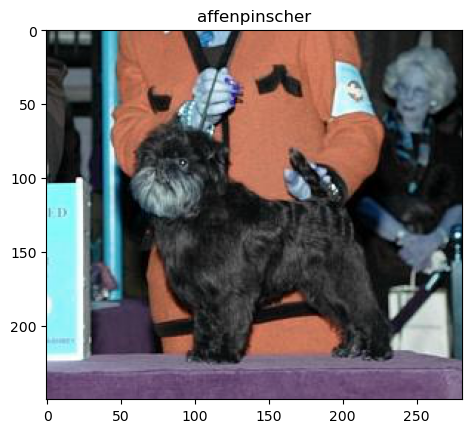

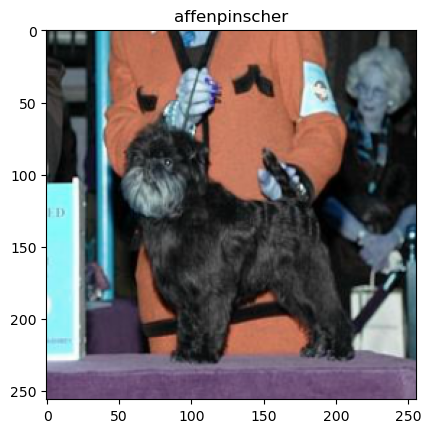

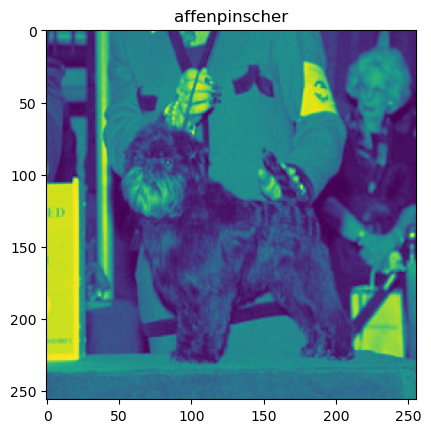

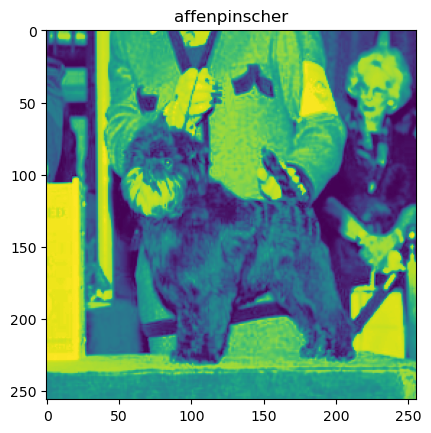

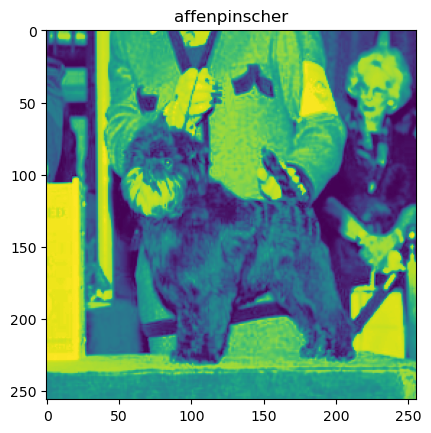

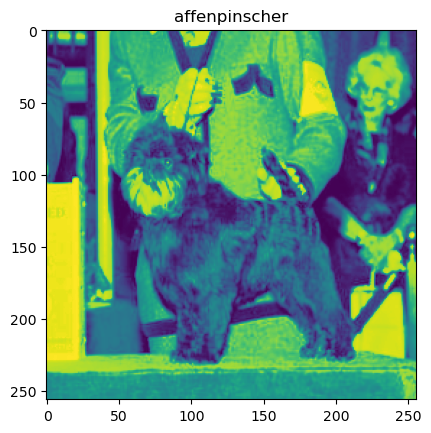

In [7]:
subdir = 'affenpinscher'

dictionaries = [preprocessed_images_by_race_clean, 
preprocessed_images_by_race_resized, preprocessed_images_by_race_gray, 
preprocessed_images_by_race_equalized, preprocessed_images_by_race_normalized, 
preprocessed_images_by_race_whitened]

for dictionary in dictionaries:
    if subdir in dictionary:
        img_list = dictionary[subdir]
        if len(img_list) > 0:
            img_test = img_list[0]
            plt.imshow(img_test)
            plt.title(subdir)
            plt.show()

### 2.2 Visualisation de la data augmentation

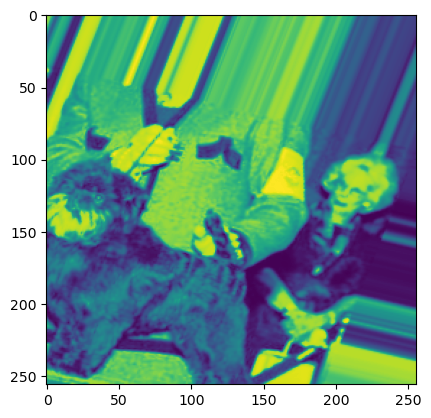

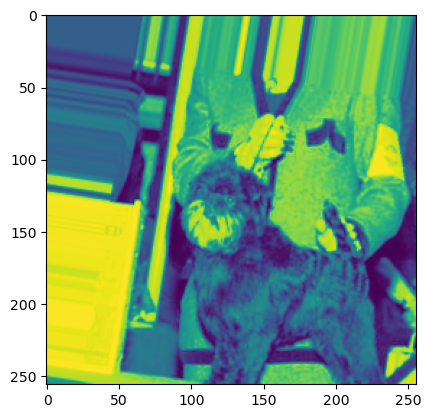

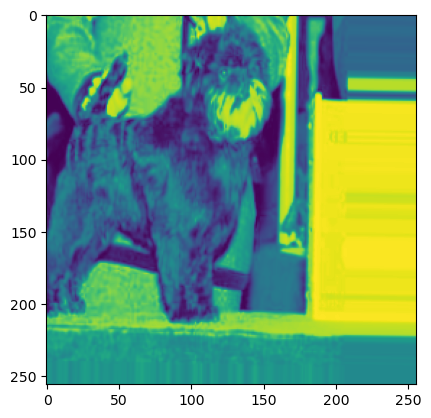

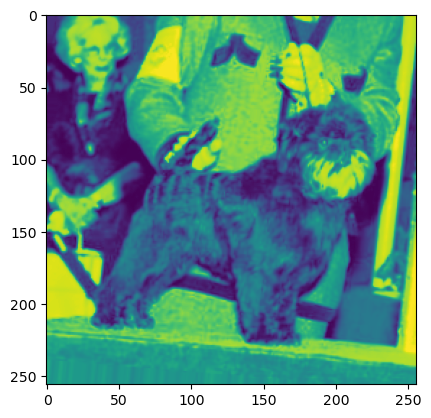

In [8]:
image_filenames = ['n02110627_10147.jpg']

for filename in image_filenames:
    for index in 1, 2, 3, 4:
        img_augmented = preprocessed_images_by_filename_augmented[filename][index]
        plt.imshow(img_augmented)
        plt.show()

## 3. Création du modèle
### 3.1 Création du training set

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  preprocessed_images_by_race,
  validation_split = 0.2,
  subset = "training",
  seed = 123,
  image_size = (256, 256),
  batch_size = 32)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.


### 3.2 Création du validation set

In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  preprocessed_images_by_race,
  validation_split = 0.2,
  subset = "validation",
  seed = 123,
  image_size = (256, 256),
  batch_size = 32)

Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


### 3.3 Récupération des étiquettes

In [11]:
class_names = train_ds.class_names
print(class_names)

['Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Blenheim_spaniel', 'Border_collie', 'Border_terrier', 'Boston_bull', 'Bouvier_des_Flandres', 'Brabancon_griffon', 'Brittany_spaniel', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Dandie_Dinmont', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'French_bulldog', 'German_shepherd', 'German_short-haired_pointer', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Ibizan_hound', 'Irish_setter', 'Irish_terrier', 'Irish_water_spaniel', 'Irish_wolfhound', 'Italian_greyhound', 'Japanese_spaniel', 'Kerry_blue_terrier', 'Labrador_retriever', 'Lakeland_terrier', 'Leonberg', 'Lhasa', 'Maltese_dog', 'Mexican_hairless', 'Newfoundland', 'Norfolk_terrier', 'Norwegian_elkhound', 'Norwich_terrier', 'Old_English_sheepdog', 'Pekinese', 'Pembroke', 'Po

### 3.4 Pipeline de traitement de données

In [14]:
# Création de deux pipelines de traitement de données (train_ds et val_ds) pour l'entraînement et la validation 
# d'un modèle d'apprentissage automatique. On utilise la mise en cache des données pour accélérer les 
# itérations d'entraînement, mélange les données d'entraînement pour introduire de l'aléatoire et précharge 
# les données pour éviter les goulots d'étranglement pendant l'entraînement. 
# Ces techniques sont couramment utilisées pour optimiser le flux de données lors de l'entraînement de modèles 
# d'apprentissage profond.

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(256, 256, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

### 3.5 Entrainement du modèle

In [15]:
history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = 10
)

Epoch 1/10
515/515 [==============================] - 279s 537ms/step - loss: 4.7375 - accuracy: 0.0171 - val_loss: 4.5864 - val_accuracy: 0.0245
Epoch 2/10
515/515 [==============================] - 301s 581ms/step - loss: 4.3676 - accuracy: 0.0475 - val_loss: 4.2682 - val_accuracy: 0.0573
Epoch 3/10
515/515 [==============================] - 308s 595ms/step - loss: 3.9972 - accuracy: 0.0909 - val_loss: 4.1615 - val_accuracy: 0.0724
Epoch 4/10
515/515 [==============================] - 322s 622ms/step - loss: 3.3817 - accuracy: 0.1992 - val_loss: 4.4053 - val_accuracy: 0.0722
Epoch 5/10
515/515 [==============================] - 308s 595ms/step - loss: 2.2388 - accuracy: 0.4299 - val_loss: 5.2736 - val_accuracy: 0.0705
Epoch 6/10
515/515 [==============================] - 298s 577ms/step - loss: 1.0146 - accuracy: 0.7263 - val_loss: 7.7179 - val_accuracy: 0.0598
Epoch 7/10
515/515 [==============================] - 333s 645ms/step - loss: 0.3712 - accuracy: 0.9032 - val_loss: 10.2810 

### 3.6 Evaluation du modèle

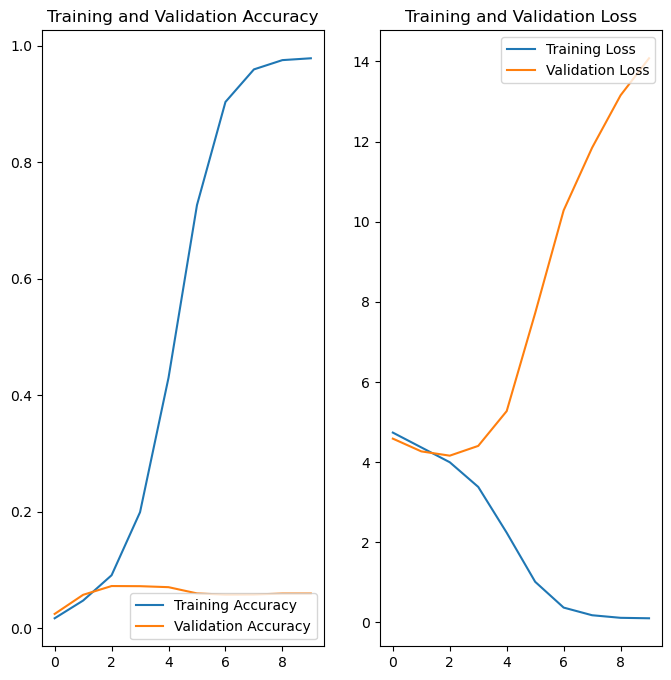

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 4.1 Prédiction

In [27]:
bull_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/b/bf/Bulldog_inglese.jpg/220px-Bulldog_inglese.jpg"
bull_path = tf.keras.utils.get_file('bul', origin=bull_url)

img = tf.keras.utils.load_img(
    bull_path, target_size=(256, 256)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 3s 3s/step
This image most likely belongs to Blenheim_spaniel with a 27.33 percent confidence.


### 4.2 Sauvegarde du modèle

In [ ]:
tf.keras.models.save_model(
    model,
    filepath="model_cnn_5_v1.00",
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True
)

On voit que le modèle performe très mal mais on va le sauvegarder tout de même pour garder la piste qui a été explorée

# <a name="C2">II. Transfer Learning</a>

## 1. VGG16

### 1.1 Train Test Split Folders

In [6]:
# Chemin vers le dossier principal contenant les sous-dossiers de races de chiens
input_folder = 'Images'

# Chemin vers le dossier où seront créés les ensembles de test et d'entraînement
output_folder = 'Train Test Split'

# Ratio de séparation entre test et train, ici 20% pour le test
ratio = 0.8

# Créer les dossiers de destination s'ils n'existent pas déjà
os.makedirs(output_folder + '/train', exist_ok=True)
os.makedirs(output_folder + '/test', exist_ok=True)

# Parcourir chaque sous-dossier de race de chien
for folder_name in os.listdir(input_folder):
    folder_path = os.path.join(input_folder, folder_name)
    
    # Vérifier si c'est bien un sous-dossier
    if os.path.isdir(folder_path):
        # Créer les sous-dossiers correspondants dans l'ensemble d'entraînement et de test
        os.makedirs(os.path.join(output_folder, 'train', folder_name), exist_ok=True)
        os.makedirs(os.path.join(output_folder, 'test', folder_name), exist_ok=True)
        
        # Obtenir la liste des fichiers d'images dans le sous-dossier
        image_files = os.listdir(folder_path)
        random.shuffle(image_files)
        
        # Calculer le nombre d'images pour l'ensemble de test en fonction du ratio
        num_test_images = int(ratio * len(image_files))
        
        # Déplacer les images dans les dossiers d'entraînement et de test
        for i, image_file in enumerate(image_files):
            src_path = os.path.join(folder_path, image_file)
            if i < num_test_images:
                dst_path = os.path.join(output_folder, 'test', folder_name, image_file)
            else:
                dst_path = os.path.join(output_folder, 'train', folder_name, image_file)
            shutil.copy(src_path, dst_path)

In [3]:
data_dir = 'Train Test Split'
img_width, img_height = 224, 224
batch_size = 32
num_classes = 120

### 1.2 Preprocessing

In [73]:
# Fonction de prétraitement des images pour le générateur de données
def preprocess_image(img):
    # Redimensionner l'image
    img = cv2.resize(img, (img_width, img_height))

    # Convertir en niveaux de gris (8 bits, un seul canal)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_img_8bit = cv2.convertScaleAbs(gray_img)

    # Égalisation de l'histogramme
    equalized_img = cv2.equalizeHist(gray_img_8bit)

    # Whitening
    mean, std = cv2.meanStdDev(equalized_img)
    whitened_img = (equalized_img - mean) / std

    # Normalisation
    whitened_img = whitened_img / 255.0

    # Ajouter une dimension supplémentaire pour correspondre au format d'entrée du modèle (batch_size, width, height, channels)
    return whitened_img.reshape((img_width, img_height, 1))

### 1.3 Data Augmentation

In [86]:
# Augmentation de données pour améliorer la généralisation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    # preprocessing_function=preprocess_image
)

In [87]:
test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
    # preprocessing_function=preprocess_image
)

### 1.4 Train, test generator

In [88]:
train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 4162 images belonging to 120 classes.


In [115]:
test_generator = test_datagen.flow_from_directory(
    os.path.join(data_dir, 'test'),
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 16418 images belonging to 120 classes.


### 1.5 Chargement du modèle

In [4]:
# Étape 3 : Charger le modèle pré-entraîné
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

In [91]:
# Étape 4 : Adapter le modèle pour votre tâche de classification
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [92]:
# Créer le modèle final
model = Model(inputs=base_model.input, outputs=predictions)

In [93]:
# Compiler le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [94]:
# Afficher un résumé du modèle
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

### 1.6 Entrainement du modèle

In [95]:
# Étape 5 : Entraîner le modèle
epochs = 10
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = test_generator.n // test_generator.batch_size

In [96]:
model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=validation_steps
)

Epoch 1/10
130/130 [==============================] - 1821s 14s/step - loss: 5.1252 - accuracy: 0.0090 - val_loss: 4.7861 - val_accuracy: 0.0116
Epoch 2/10
130/130 [==============================] - 1788s 14s/step - loss: 4.7865 - accuracy: 0.0121 - val_loss: 4.7847 - val_accuracy: 0.0122
Epoch 3/10
130/130 [==============================] - 1840s 14s/step - loss: 4.7852 - accuracy: 0.0116 - val_loss: 4.7834 - val_accuracy: 0.0122
Epoch 4/10
130/130 [==============================] - 1835s 14s/step - loss: 4.7842 - accuracy: 0.0104 - val_loss: 4.7822 - val_accuracy: 0.0122
Epoch 5/10
130/130 [==============================] - 1846s 14s/step - loss: 4.7832 - accuracy: 0.0121 - val_loss: 4.7810 - val_accuracy: 0.0122
Epoch 6/10
130/130 [==============================] - 1860s 14s/step - loss: 4.7823 - accuracy: 0.0121 - val_loss: 4.7803 - val_accuracy: 0.0122
Epoch 7/10
130/130 [==============================] - 1812s 14s/step - loss: 4.7819 - accuracy: 0.0121 - val_loss: 4.7799 - val_ac

In [97]:
# Étape 6 : Évaluer le modèle
score = model.evaluate(test_generator, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 4.779185771942139
Test accuracy: 0.012242660857737064


Les résultats sont trop mauvais pour que le modèle soit enregistrer

### 2. MobileNetV2

In [5]:
# Chemin vers le dossier principal contenant les sous-dossiers d'images de chiens
data_dir = "Images"

In [6]:
# Paramètres
images = []
labels = []
img_height, img_width = 128, 128
batch_size = 32
epochs = 10

In [7]:
# Charger les images et leurs étiquettes depuis le dossier
def load_data(data_dir):
    breed_list = sorted(os.listdir(data_dir))
    for breed_idx, breed in enumerate(breed_list):
        breed_folder = os.path.join(data_dir, breed)
        for img_file in os.listdir(breed_folder):
            img_path = os.path.join(breed_folder, img_file)
            img = tf.keras.preprocessing.image.load_img(
                img_path, target_size=(img_height, img_width)
            )
            img = tf.keras.preprocessing.image.img_to_array(img)
            img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
            images.append(img)
            labels.append(breed_idx)
    return np.array(images), np.array(labels)

In [8]:
# Charger les données
images, labels = load_data(data_dir)

In [9]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [10]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [11]:
datagen.fit(X_train)

In [12]:
# Créer le modèle basé sur le MobileNetV2 en utilisant le transfer learning
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(len(set(labels)), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [13]:
# Geler les couches du modèle de base
for layer in base_model.layers:
    layer.trainable = False

In [14]:
# Compiler le modèle
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [15]:
# Entraîner le modèle
model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=epochs)

Epoch 1/10
492/492 [==============================] - 46s 92ms/step - loss: 1.8373 - accuracy: 0.5158
Epoch 2/10
492/492 [==============================] - 46s 94ms/step - loss: 1.2508 - accuracy: 0.6393
Epoch 3/10
492/492 [==============================] - 47s 96ms/step - loss: 1.1088 - accuracy: 0.6710
Epoch 4/10
492/492 [==============================] - 48s 98ms/step - loss: 1.0162 - accuracy: 0.6977
Epoch 5/10
492/492 [==============================] - 48s 97ms/step - loss: 0.9423 - accuracy: 0.7121
Epoch 6/10
492/492 [==============================] - 48s 97ms/step - loss: 0.8814 - accuracy: 0.7299
Epoch 7/10
492/492 [==============================] - 49s 99ms/step - loss: 0.8441 - accuracy: 0.7389
Epoch 8/10
492/492 [==============================] - 49s 100ms/step - loss: 0.7711 - accuracy: 0.7593
Epoch 9/10
492/492 [==============================] - 48s 98ms/step - loss: 0.7258 - accuracy: 0.7734
Epoch 10/10
492/492 [==============================] - 48s 98ms/step - loss: 0.67

In [16]:
# Évaluer le modèle
_, test_accuracy = model.evaluate(X_test, y_test)
print("Test accuracy:", test_accuracy)

123/123 [==============================] - 11s 86ms/step - loss: 1.2104 - accuracy: 0.6864
Test accuracy: 0.6864191293716431


In [17]:
# Prédictions sur l'ensemble de test
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

123/123 [==============================] - 11s 87ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.53      0.50        32
           1       0.62      0.71      0.67        35
           2       0.92      0.87      0.89        38
           3       0.81      0.69      0.75        36
           4       0.77      0.83      0.80        24
           5       0.64      0.74      0.68        34
           6       0.83      0.74      0.78        34
           7       0.63      0.79      0.70        43
           8       1.00      0.35      0.51        26
           9       0.83      0.76      0.79        25
          10       0.82      0.70      0.76        20
          11       0.61      0.61      0.61        28
          12       0.64      0.73      0.68        37
          13       0.52      0.67      0.59        33
          14       0.96      0.71      0.82        38
          15       0.65      0.67      0.66        36
 

In [18]:
# Fonction pour télécharger l'image depuis l'URL et la prétraiter
def preprocess_image_from_url(image_url):
    response = requests.get(image_url)
    img = Image.open(io.BytesIO(response.content))
    img = img.resize((img_width, img_height))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

In [19]:
# Charger la liste des noms de races de chiens
breed_list = sorted(os.listdir(data_dir))

In [25]:
# URL de l'image à prédire
image_url = "https://www.thesprucepets.com/thmb/5s_34Cf4OqS8e3p4zaJ-El5eGXw=/2121x0/filters:no_upscale():strip_icc()/GettyImages-988045138-5be0740146e0fb0026ddae02.jpg"

# Prétraiter l'image et effectuer la prédiction
processed_image = preprocess_image_from_url(image_url)
prediction = model.predict(processed_image)
predicted_class = np.argmax(prediction)

# Afficher le résultat de la prédiction
print("Prédiction:", breed_list[predicted_class])

1/1 [==============================] - 2s 2s/step
Prédiction: Afghan_hound


In [27]:
tf.keras.models.save_model(
    model,
    filepath="model_transfer_v1.1",
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True
)

INFO:tensorflow:Assets written to: model_transfer_v1.1\assets


INFO:tensorflow:Assets written to: model_transfer_v1.1\assets


### 2.1 MobileNetV2 avec 20 batch, 224x224

In [89]:
# Paramètres
img_height, img_width = 224, 224
batch_size = 32
epochs = 20

In [12]:
# Entraîner le modèle
model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=epochs)

Epoch 1/20
492/492 [==============================] - 156s 313ms/step - loss: 1.3762 - accuracy: 0.6288
Epoch 2/20
492/492 [==============================] - 142s 288ms/step - loss: 0.8329 - accuracy: 0.7425
Epoch 3/20
492/492 [==============================] - 146s 296ms/step - loss: 0.7200 - accuracy: 0.7731
Epoch 4/20
492/492 [==============================] - 143s 290ms/step - loss: 0.6650 - accuracy: 0.7891
Epoch 5/20
492/492 [==============================] - 147s 299ms/step - loss: 0.6037 - accuracy: 0.8095
Epoch 6/20
492/492 [==============================] - 147s 299ms/step - loss: 0.5480 - accuracy: 0.8214
Epoch 7/20
492/492 [==============================] - 147s 298ms/step - loss: 0.5272 - accuracy: 0.8287
Epoch 8/20
492/492 [==============================] - 149s 303ms/step - loss: 0.4807 - accuracy: 0.8416
Epoch 9/20
492/492 [==============================] - 151s 306ms/step - loss: 0.4384 - accuracy: 0.8545
Epoch 10/20
492/492 [==============================] - 148s 301m

In [13]:
# Évaluer le modèle
_, test_accuracy = model.evaluate(X_test, y_test)
print("Test accuracy:", test_accuracy)

123/123 [==============================] - 31s 251ms/step - loss: 0.9656 - accuracy: 0.7848
Test accuracy: 0.784842312335968


In [14]:
# Prédictions sur l'ensemble de test
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

123/123 [==============================] - 30s 238ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.69      0.70        32
           1       0.69      0.71      0.70        35
           2       1.00      0.95      0.97        38
           3       0.89      0.92      0.90        36
           4       0.80      1.00      0.89        24
           5       0.62      0.94      0.74        34
           6       0.94      0.91      0.93        34
           7       0.90      0.84      0.87        43
           8       0.93      0.54      0.68        26
           9       0.89      0.96      0.92        25
          10       0.88      0.75      0.81        20
          11       0.64      0.57      0.60        28
          12       0.78      0.84      0.81        37
          13       0.92      0.73      0.81        33
          14       0.94      0.82      0.87        38
          15       0.66      0.75      0.70        36


In [21]:
# URL de l'image à prédire
image_url = "https://images.ctfassets.net/440y9b545yd9/Y9gB3irmojuBsdPo6pc39/b5ef99988db3a04a3357b07ea0abe0c3/Afghan_Hound850__1_.jpg"

# Prétraiter l'image et effectuer la prédiction
processed_image = preprocess_image_from_url(image_url)
prediction = model.predict(processed_image)
predicted_class = np.argmax(prediction)

# Charger la liste des noms de races de chiens
data_dir = "Images"
breed_list = sorted(os.listdir(data_dir))

# Afficher le résultat de la prédiction
print("Prédiction:", breed_list[predicted_class])

1/1 [==============================] - 0s 338ms/step
Prédiction: cocker_spaniel


In [19]:
tf.keras.models.save_model(
    model,
    filepath="model_transfer_v1.2",
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True
)

INFO:tensorflow:Assets written to: model_transfer_v1.2\assets


INFO:tensorflow:Assets written to: model_transfer_v1.2\assets


### 3. Resnet

### 4. Inception

### 5. EfficientNet

### 6. MobileNetV3